In [1]:
import easyocr
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from box_cluster import get_clusters, cluster_boxes

In [2]:
def imread(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
# pip install weasyprint

In [4]:
reader = easyocr.Reader(['ru', 'en'], gpu=True)

In [5]:
paths = glob.glob('data/*/images/*.jpg') + glob.glob('data/*/images/*.png')
paths.sort()

In [6]:
len(paths)

926

In [7]:
path = paths[1]
path

'data/tg/images/0167a729-d2d4-49ac-8054-a92b61bd0165.jpg'

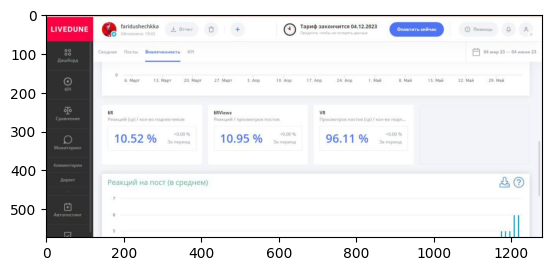

In [8]:
plt.imshow(imread(path))

In [9]:
%%time
result = reader.readtext(path)

CPU times: user 3.9 s, sys: 412 ms, total: 4.31 s
Wall time: 1.41 s


In [10]:
image = imread(path)
boxes = [np.array(item[0]) for item in result]
texts = [np.array(item[1]) for item in result]

len(boxes)

52

In [12]:
from graph_cluster import agglomerative_cluster_boxes, compute_area, compute_centroid, box_to_bbox

In [13]:
def visualize_clusters_on_image(img, clustered_boxes):
    # Загрузка изображения
    fig, ax = plt.subplots()
    ax.imshow(img)

    for cluster, boxes in clustered_boxes.items():
        # Получаем бокс с самой большой площадью в кластере
        bboxes = [box_to_bbox(box) for box in boxes]
        areas = [compute_area(bbox) for bbox in bboxes]
        max_area_index = np.argmax(areas)
#         central_box = boxes[max_area_index]
        central_box = boxes[0]

        central_centroid = compute_centroid(central_box)
        for box in boxes:
            centroid = compute_centroid(box)
            
            # Нанесение линии от центра кластера до каждого бокса
            plt.plot([centroid[0], central_centroid[0]], [centroid[1], central_centroid[1]], '-o', color='blue')
            
            # Нанесение бокса на изображение
            bbox = box_to_bbox(box)
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.show()

In [15]:
n_clusters = 14  # or whatever number of clusters you want
clustered_boxes, clustered_texts = agglomerative_cluster_boxes(boxes, texts, n_clusters)
# visualize_clusters(clustered_boxes)

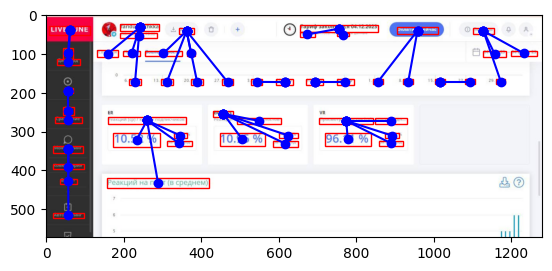

In [17]:
visualize_clusters_on_image(image, clustered_boxes)

In [18]:
for idx, cluster in clustered_boxes.items():
    cluster_color = tuple(np.random.randint(0, 255, 3).tolist())
    for box in cluster:
        pts = np.array(box, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(image, [pts], isClosed=True, color=cluster_color, thickness=2)

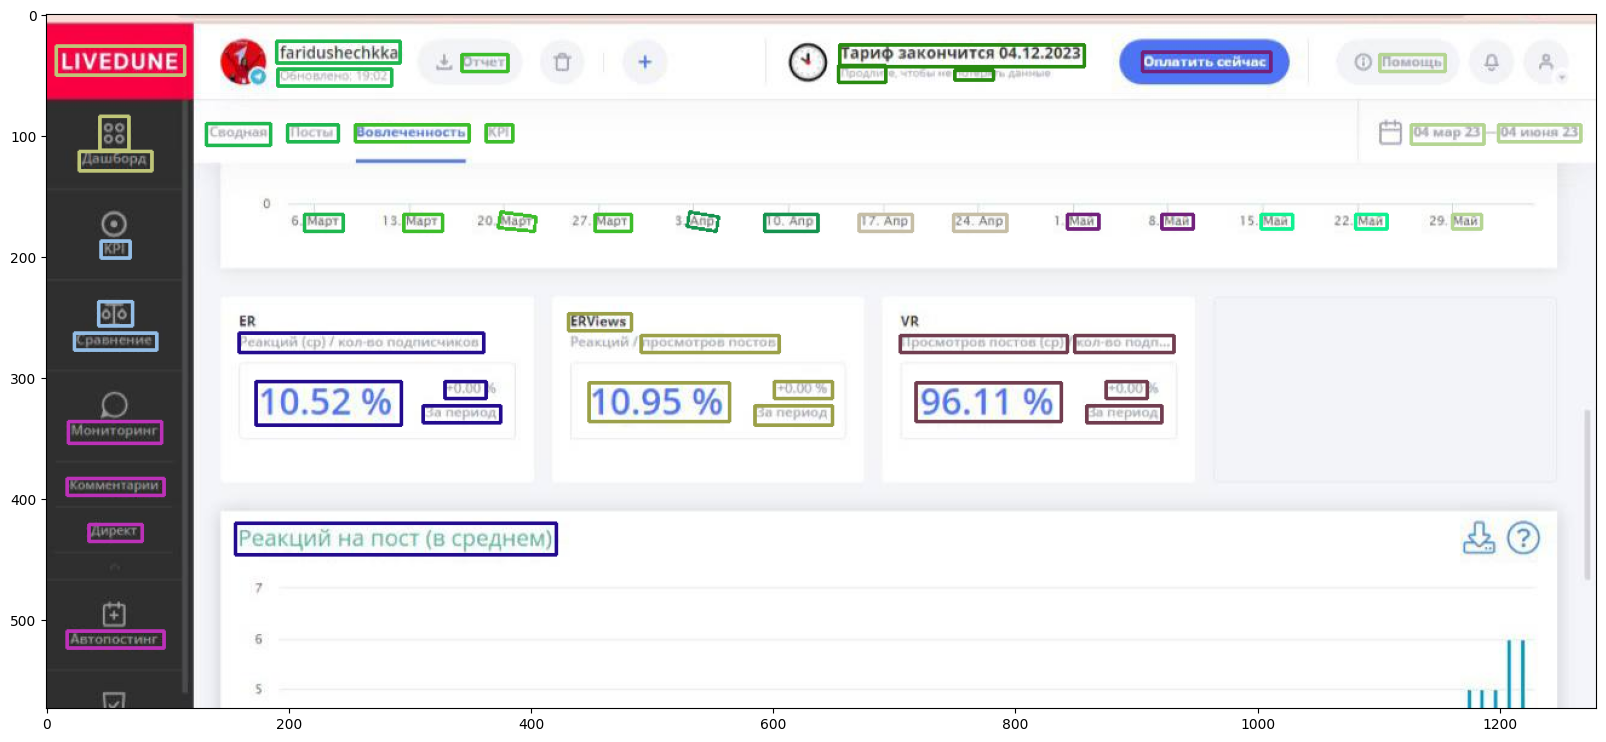

In [19]:
plt.figure(figsize=(20, 20))
plt.imshow(image)

In [21]:
for idx, cluster in clustered_texts.items():
    break

In [23]:
text_line = " ".join([str(c) for c in cluster])

In [25]:
# pip install python-Levenshtein
# pip install fuzzywuzzy
from fuzzywuzzy import fuzz

In [28]:
keyword = 'подписчики'
fuzz_thresh = 80

In [29]:
roi_lines = []

for cluster in clustered_texts.values():
    cluster_text = " ".join([str(c) for c in cluster]).lower()
    
    print(cluster_text)
    
    if not any([s.isnumeric() for s in cluster_text.split()]):
        continue
    
    if fuzz.partial_ratio(keyword, cluster_text) > 80:
        print(f'\t\t\t\tНайдено ключевое слово в {cluster_text}')

livedune 88 дашборд
faridushechkka панавлако}19д? сваднам посты maрт
отчет вовлеченность kpi март mирт март
тариф закончится 04.12.2023 продль прг
ошштитьссичце ман man
памощы (мар 2 04 мюми 2 mаk
10, алр anp
17  апр 24 anp
ман май
kpi оo српвненне
ervicws процмотров nоcтar 20,00 %5 10.95 % зй пермод
реmий (е) гкол-но подписчико8 #0,00 10.52 % за пормол реакций на пост (в среднем)
просмотрав пастод [cp) kал-u9 падп+++ 40,00 96.11 % яn nеpнол
мониторинг коммиситрии ширент двтапостинг


'Городской методи  .'

In [92]:
from fuzzywuzzy import fuzz
import re

def find_keyword_and_number_in_clusters(texts_by_clusters, keyword):
    keyword_found_in_cluster = []
    
    # Регулярное выражение для поиска числа рядом с ключевым словом
    # Это предполагает, что между ключевым словом и числом может быть пробел, но не другие символы
    regex_pattern = f"{keyword}\s*(\d+)"

    for cluster_texts in texts_by_clusters:
        # Объединяем тексты внутри кластера в одну строку
        full_text = ' '.join(cluster_texts)
        
        # Проверяем, содержит ли строка ключевое слово с использованием fuzzy matching
        if fuzz.partial_ratio(keyword, full_text) > 80:  # Вы можете изменить пороговое значение по вашему усмотрению
            match = re.search(regex_pattern, full_text, re.IGNORECASE)
            if match:
                keyword_found_in_cluster.append((full_text, match.group(1)))  # (текст кластера, найденное число)
            else:
                keyword_found_in_cluster.append((full_text, None))
    
    return keyword_found_in_cluster

# Применение
keyword = "ВашКлючевойТерм"
results = find_keyword_and_number_in_clusters(texts_by_clusters, keyword)

for cluster_text, number in results:
    print(f"Текст кластера: {cluster_text}")
    if number:
        print(f"Найденное число рядом с ключевым словом: {number}")
    else:
        print("Число рядом с ключевым словом не найдено")


ModuleNotFoundError: No module named 'fuzzywuzzy'

In [93]:
!pip install fuzzywuzzy